# Autoencoder

This notebook is an implementation of a simple autoencoder and classifier. For input I will consume a dataset of fonts from [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Multiple+Features). It comprises of 2000 handwritten digits (0 through 9). It offers different features, however I will only use the pixel features, since it is the most raw. Each pixel is an average of a $2 \times 3$ window over the original image as a grayscale value.


## Prerequisites

This Jupyter notebook uses the Julia kernel (v1.7.1) and thus requires it. The dataset is included in the repository, so there is no need to download it.

## Architecture

The model consists of 3 components:

- An **encoder** whose job is to reduce the input space to a smaller representation. This will be a convolutional neural network, this will improve the quality of extracted features.
- A **decoder** receives the output of the encoder and tries to reconstruct the original input. This will be a dense neural network.
- A **classifier** will take encoder's output and learn to classify it to appropriate classes. This will also be a dense neural network.

![Architecture](assets/architecture.png)

## Installing dependencies

In [59]:
import Pkg
# For ML primitives
Pkg.add("Flux")
# For ploting
Pkg.add("Plots")
# For basic benchmarking
Pkg.add("BenchmarkTools")
# For decompressing Gzip files
Pkg.add("GZip")
# For displaying images
Pkg.add("Images")
# Utility for showing loop progress
Pkg.add("ProgressMeter")
# Binary serde: saves/loads models
Pkg.add("BSON")
# For notebook interactive components
# For it to work, install the `webio_jupyter_extension` extension: 
# `python3 -m pip install --upgrade webio_jupyter_extension`
Pkg.add("Interact")
Pkg.add("WebIO")

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`
   Resolving package versions...
   Installed BSON ─ v0.3.4
    Updating `~/.julia/environments/v1.7

## Reading data

In [17]:
using GZip

# dimensions of the image
const DIM = (15, 16)
# data size used
const DATA_TYPE = Float16
# amount of classes
const N_CLASSES = 10

dataset = GZip.open("assets/mfeat-pix.gz") do io
    data = readlines(io) .|> 
        # skip spaces in file
        x -> x[3:3:end] |>
        # get chars
        collect .|>
        # parse to integer
        x -> parse(Int, x)
    # transform to matrix
    data = permutedims(hcat(data...))
    # normalize and transform to row major
    DATA_TYPE.(data ./ maximum(data))'
end

240×2000 adjoint(::Matrix{Float16}) with eltype Float16:
 0.0     0.0     0.0     0.0     0.0     …  0.0     0.0     0.0     0.0
 0.5     0.0     0.0     0.0     0.0        0.0     0.0     0.0     0.0
 0.6665  0.0     0.1666  0.5     0.0        0.0     0.0     0.0     0.1666
 0.6665  0.0     0.6665  0.5     0.0        0.0     0.3333  0.0     0.8335
 1.0     0.0     0.6665  0.3333  0.0        0.5     0.6665  0.0     1.0
 1.0     0.0     0.6665  0.3333  0.0     …  1.0     0.6665  0.0     1.0
 1.0     0.1666  0.6665  0.6665  0.5        1.0     0.6665  0.3333  1.0
 1.0     0.5     0.6665  0.8335  0.6665     1.0     1.0     0.6665  1.0
 1.0     0.6665  0.6665  1.0     1.0        1.0     0.6665  0.6665  1.0
 0.8335  0.6665  0.5     1.0     1.0        1.0     0.6665  0.8335  1.0
 0.5     0.6665  0.0     1.0     0.6665  …  1.0     0.3333  0.8335  1.0
 0.1666  0.6665  0.0     0.5     0.5        0.8335  0.0     0.6665  0.6665
 0.0     0.6665  0.0     0.0     0.0        0.1666  0.0     0.1666  0.

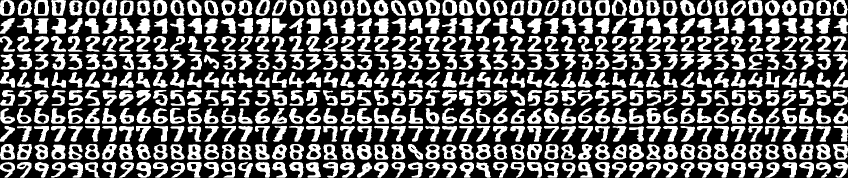

In [18]:
using Images

# returns an Images representation of an instance
img(d) = Gray.(reshape(d, DIM)')

# retrieves columns of a matrix as a view
columns(matrix) = @views [dataset[:, i] for i in 1:size(dataset, 2)]

# visual some data
mosaicview(img.(columns(dataset)[1:4:end]), npad=2, nrow=N_CLASSES, rowmajor=true)

The data looks ok and is distinguishable by human, however digit '1' looks very noisy.

In [19]:
using Flux: onehotbatch, DataLoader

# create labels
labels = [(i-1) ÷ 200 for i in 1:size(dataset, 2)]

# create a sparse matrix representing the classifier output vectors
ys = onehotbatch(labels, 0:N_CLASSES-1)

# split into train/test (80/20) set
const TRAIN_FRAC = 0.8

(c_train_x, c_train_y), (c_test_x, c_test_y) = DataLoader(
    (dataset, ys), batchsize=size(dataset)[end] * TRAIN_FRAC |> floor |> Int, shuffle=true)

(ae_train_x, ae_train_y), (ae_test_x, ae_test_y) = DataLoader(
    (dataset, dataset), batchsize=size(dataset)[end] * TRAIN_FRAC |> floor |> Int, shuffle=true)

DataLoader{Tuple{LinearAlgebra.Adjoint{Float16, Matrix{Float16}}, LinearAlgebra.Adjoint{Float16, Matrix{Float16}}}, Random._GLOBAL_RNG}((Float16[0.0 0.0 … 0.0 0.0; 0.5 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], Float16[0.0 0.0 … 0.0 0.0; 0.5 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]), 1600, 2000, true, 2000, [1097, 108, 348, 69, 397, 1657, 1289, 1121, 1836, 716  …  1254, 1305, 1159, 1173, 798, 728, 503, 1740, 807, 1805], true, Random._GLOBAL_RNG())

## Constructing the model

[FluxML](https://fluxml.ai/) will be used for ML primitives. It offers a compile time Automatic-Differentiation engine, [Zygote](https://github.com/FluxML/Zygote.jl). There is no handwritten gradient calculation code.

### Hyperparameters

In [35]:
using Flux

# learning rate
const α = 3e-4

const BATCH_SIZE = 32

const LATENT_DIM = 2

# the dataset is so small we can go crazy with the number of epochs
const EPOCHS = 10000

# gradient optimizer
opt = ADAM(α)

# loss function that will be optimized
loss(ŷ, y) = logitcrossentropy(ŷ, y)

encoder = Chain(Dense(prod(DIM), 128, relu), Dense(128, LATENT_DIM, tanh))
decoder = Chain(Dense(LATENT_DIM, 128, relu), Dense(128, prod(DIM), σ))
classifier = Chain(Dense(LATENT_DIM, 32, relu), Dense(32, N_CLASSES))

autoencoder = Chain(encoder, decoder)
full_classifier = Chain(encoder, classifier)

# model parameters, used by Zygote to extract gradients
ae_ps = Flux.params(autoencoder);
# for the classifier, we do not want to update the encoder weights
c_ps = Flux.params(classifier);

### Testing function

For testing, the loss and overall accuracy TODO: 2 testing function for classifier and autoencoder

In [36]:
using Flux: onecold, logitcrossentropy

function c_accuracy(data_loader, model)
    acc = 0
    num = 0
    for (x, y) in data_loader
        ŷ = model(x)
        acc += sum(onecold(ŷ) .== onecold(y))
        num +=  size(x)[end]
    end
    return acc / num
end

function c_loss(data_loader, model)
    ls = 0.0f0
    num = 0
    for (x, y) in data_loader
        ŷ = model(x)
        ls += logitcrossentropy(ŷ, y, agg=sum)
        num +=  size(x)[end]
    end
    return ls / num
end

function ae_loss(data_loader, model)
    ls = 0.0f0
    num = 0
    for (x, y) in data_loader
        ŷ = model(x)
        ls += logitcrossentropy(ŷ, y, agg=sum)
        num +=  size(x)[end]
    end
    return ls / num
end

ae_loss (generic function with 1 method)

In [63]:
using ProgressMeter

ae_train_loader = DataLoader((ae_train_x, ae_train_y), batchsize=BATCH_SIZE, shuffle=true)
ae_test_loader = DataLoader((ae_test_x, ae_test_y), batchsize=BATCH_SIZE)

ae_losses_train = [ae_loss(ae_train_loader, autoencoder)]
ae_losses_test = [ae_loss(ae_test_loader, autoencoder)]

@showprogress for epoch in 1:EPOCHS
    for (x, y) in ae_train_loader
        ∇ = gradient(ae_ps) do 
            loss(autoencoder(x), y)
        end
        Flux.Optimise.update!(opt, ae_ps, ∇)
    end
    
    push!(ae_losses_train, ae_loss(ae_train_loader, autoencoder))
    push!(ae_losses_test, ae_loss(ae_test_loader, autoencoder))
end

Progress: 100%|█████████████████████████████████████████| Time: 0:04:29


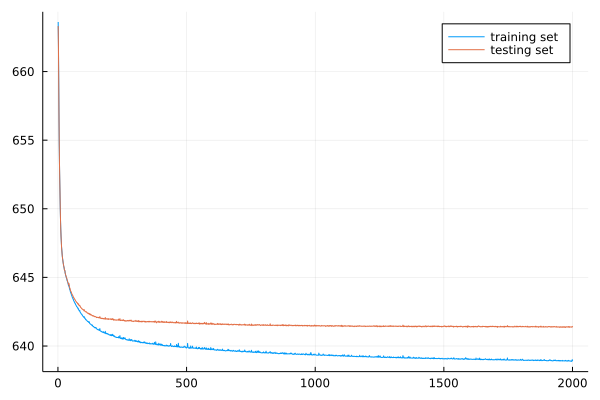

In [64]:
using Plots

plot(ae_losses_train, label="training set")
plot!(ae_losses_test, label="testing set")

In [69]:
c_train_loader = DataLoader((c_train_x, c_train_y), batchsize=BATCH_SIZE, shuffle=true)
c_test_loader = DataLoader((c_test_x, c_test_y), batchsize=BATCH_SIZE)

c_losses_train = [c_loss(c_train_loader, full_classifier)]
c_losses_test = [c_loss(c_test_loader, full_classifier)]
c_acc_train = [c_accuracy(c_train_loader, full_classifier)]
c_acc_test = [c_accuracy(c_test_loader, full_classifier)]

@showprogress for epoch in 1:EPOCHS
    for (x, y) in c_train_loader
        ∇ = gradient(c_ps) do 
            loss(full_classifier(x), y)
        end
        Flux.Optimise.update!(opt, c_ps, ∇)
    end
    
    push!(c_losses_train, c_loss(c_train_loader, full_classifier))
    push!(c_losses_test, c_loss(c_test_loader, full_classifier))
    push!(c_acc_train, c_accuracy(c_train_loader, full_classifier))
    push!(c_acc_test, c_accuracy(c_test_loader, full_classifier))
end

Progress: 100%|█████████████████████████████████████████| Time: 0:03:35


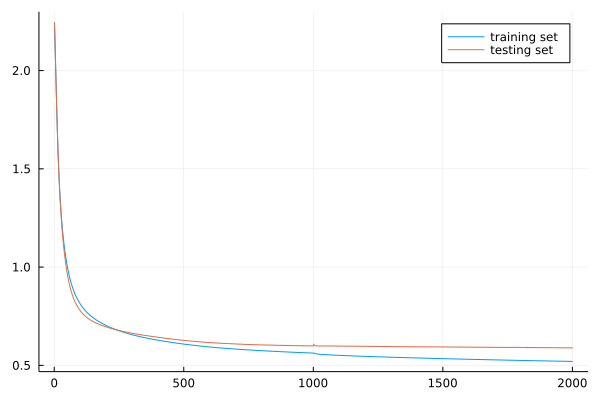

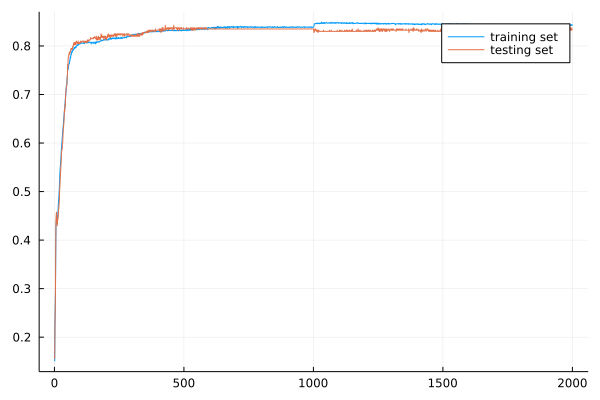

In [70]:
plot(c_losses_train, label="training set")
display(plot!(c_losses_test, label="testing set"))

plot(c_acc_train, label="training set")
display(plot!(c_acc_test, label="testing set"))

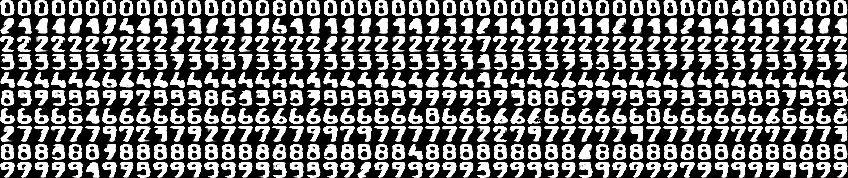

In [75]:
mosaicview(img.(autoencoder.(columns(dataset)[1:4:end])), npad=2, nrow=N_CLASSES, rowmajor=true)

In [62]:
using BSON: @save

@save "assets/encoder.bson" encoder
@save "assets/decoder.bson" decoder
@save "assets/classifier.bson" classifier

In [66]:
using Interact

@manipulate for l1=-1:0.01:1, l2=-1:0.01:1
    img(decoder([l1; l2]))
end

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["l1"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 201, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget")), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing), "index" => (Observable{Any} with 2 listeners. Value:
101, nothing)), Set{String}(), nothing, Asset[Asset("js", "knockout", "/home/shilangyu/.julia/packages/Knockout/3gjS1/src/../assets/knockout.js"), Asset("js", "knockout_punches", "/home/shilangyu/.julia/packages/Knockout/3gjS1/src/../assets/knockout_punches.js"), Asset("js", nothing, "/home/shilangyu/.julia/packages/InteractBase/o1I6G/src/../assets/all.js"), Asset("css", nothing, "/home/shilangyu/.julia/packages/InteractBase/o1I6G/src/../assets/style.css"), Asset("css", nothing, "/home/shilangyu/.julia/packages/Interact/pVyN2/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007f4ebfd59430, Task (runnable) @0x00007f4ebfd59430), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"-1.0\",\"-0.99\",\"-0.98\",\"-0.97\",\"-0.96\",\"-0.95\",\"-0.94\",\"-0.93\",\"-0.92\",\"-0.91\",\"-0.9\",\"-0.89\",\"-0.88\",\"-0.87\",\"-0.86\",\"-0.85\",\"-0.84\",\"-0.83\",\"-0.82\",\"-0.81\",\"-0.8\",\"-0.79\",\"-0.78\",\"-0.77\",\"-0.76\",\"-0.75\",\"

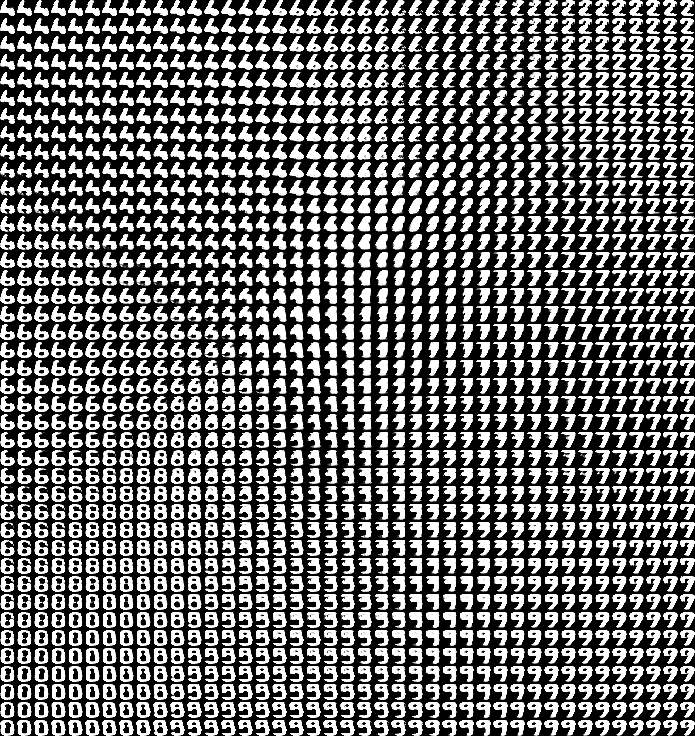

In [98]:
mosaicview(img.(decoder.([x; y] for x in -1:0.05:1 for y in -1:0.05:1)), npad=2, nrow=41, rowmajor=true)

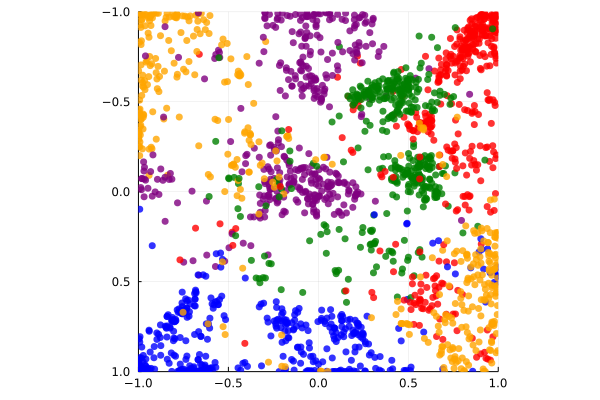

In [97]:
plt = scatter(palette=:rainbow, xrange=(-1, 1), yrange=(-1, 1), yflip=true)
for (x, y) in zip(columns(dataset), labels)
    l1, l2 = encoder(x)
    scatter!([l1], [l2],
        markerstrokewidth=0, markeralpha=0.8,
        aspect_ratio=1,
        markercolor=y, label="")
end
plt

## References

- https://towardsdatascience.com/understanding-latent-space-in-machine-learning-de5a7c687d8d
- https://archive.ics.uci.edu/ml/datasets/Multiple+Features